# Guide on how to use the backtester

In [2]:
# Ensure the project root is in PATH.
import sys
sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [3]:
def size_function(z, edge_0, edge_max, max_position = 50):
    z = np.array(z)
    direction = np.where(z > 0, -1, 1)
    abs_z = np.abs(z)
    size = np.where(
        abs_z <= edge_0,
        0,
        np.where(
            abs_z >= edge_max,
            max_position,
            max_position * ((abs_z - edge_0) / (edge_max - edge_0)) ** 2
        )
    )
    return direction * size

def exit_size_function(z, edge_0, edge_max, max_position = 50):
    # Positive quadratic function with points (0, 0) and (-2, 50)
    if z <= 0:
        if z >= -edge_0:
            return 0
        elif z <= -edge_max:
            return max_position
            
        a = -max_position/(edge_max - edge_0)**2
        return a * (z + edge_max)**2 + max_position
    else:
        if z <= edge_0:
            return 0
        elif z >= edge_max:
            return -max_position
        a = max_position/(edge_max - edge_0)**2
        return a * (z-edge_max)**2 - max_position


In [20]:
class Trader:

    kelp_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])

    resin_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])

    squink_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])
    # “If none of the bots trade on an outstanding player quote, the quote is automatically cancelled at the end of the iteration.”

    # I think this might make knowing which curve to move on easier, but what if the spread jumps from -50 to +50? 
    # We will def want to close out. I guess it depends on current position then
    z_ask = ""
    z_bid = ""
    
    def update_df(df, product, state, orders, order_depth):
        buy_orders = sorted(order_depth.buy_orders.items(), key=lambda x: -x[0])
        sell_orders = sorted(order_depth.sell_orders.items(), key=lambda x: x[0])

        bid_levels = buy_orders[:3] + [(None, None)] * (3 - len(buy_orders))
        ask_levels = sell_orders[:3] + [(None, None)] * (3 - len(sell_orders))

        if bid_levels[0][0] is not None and ask_levels[0][0] is not None:
            mid_price = (bid_levels[0][0] + ask_levels[0][0]) / 2
        else:
            mid_price = None

        row = {
            "timestamp": state.timestamp,
            "product": product,
            "bid_price_1": bid_levels[0][0], "bid_volume_1": bid_levels[0][1],
            "bid_price_2": bid_levels[1][0], "bid_volume_2": bid_levels[1][1],
            "bid_price_3": bid_levels[2][0], "bid_volume_3": bid_levels[2][1],
            "ask_price_1": ask_levels[0][0], "ask_volume_1": ask_levels[0][1],
            "ask_price_2": ask_levels[1][0], "ask_volume_2": ask_levels[1][1],
            "ask_price_3": ask_levels[2][0], "ask_volume_3": ask_levels[2][1],
            "mid_price": mid_price,
        }

        df.loc[len(df)] = row



    def run(self, state: TradingState):
        # Only method required. It takes all buy and sell orders for all symbols as an input, and outputs a list of orders to be sent

        result = {}
        best_ask_b1 = 0
        best_bid_b1 = 0
        best_ask_v_b1 = 0
        best_bid_v_b1 = 0

        best_ask_b2= 0
        best_bid_b2 = 0
        best_ask_v_b2 = 0
        best_bid_v_b2 = 0
        
        for product in state.order_depths:
            order_depth: OrderDepth = state.order_depths[product]
            orders: List[Order] = []
            
            if product == 'PICNIC_BASKET1':
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_b1, best_ask_v_b1 = list(order_depth.sell_orders.items())[0]
                    best_bid_b1, best_bid_v_b1 = list(order_depth.buy_orders.items())[0]

            if product == 'PICNIC_BASKET2':
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_b2, best_ask_v_b2 = list(order_depth.sell_orders.items())[0]
                    best_bid_b2, best_bid_v_b2 = list(order_depth.buy_orders.items())[0]

        available_sell = min(int(best_bid_v_b1), int(best_bid_v_b2))   # How many we can sell synthetica lly
        available_buy = min(int(abs(best_ask_v_b1)), int(abs(best_ask_v_b2)))    # How many we can buy synthetically

        edge_0 = 0.0005
        edge_max = 0.001

        edge_max_retreet = 0.0008
        edge_0_retreet = 0.0002

        position_max = int(60)

        basket_2_position = state.position.get("PICNIC_BASKET2", 0)
        basket_1_position = state.position.get("PICNIC_BASKET1", 0)


        # Redoing entry and exit scheme:
        z_mid = (best_ask_b2 + best_ask_b2)/(best_ask_b1 + best_ask_b1) - 0.5150
        
        pos_buy = size_function(z_mid, edge_0, edge_max, position_max)
        pos_sell = exit_size_function(z_mid, edge_0_retreet, edge_max_retreet, position_max)

        # Interms of basket 2? Ratio high = sell basket 2
        if z_mid > 0:
            # We only move on the entry curve. Enter more or hold.
           
            if pos_buy <= basket_1_position:
                print("On the entry curve")
                target_position = pos_buy
                trade_needed = int(target_position - basket_2_position)
                trade_multiplier = min(abs(trade_needed), available_buy)
                print(available_buy, abs(trade_needed))
                print(trade_multiplier)
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_bid_b2, -trade_multiplier)]
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_ask_b1, trade_multiplier)]

                print(f"In z_mid > 0, and entering. position: {basket_2_position}, target_position: {target_position}, trade_needed: {trade_needed}")

            else:
                print("Not on entry curve")
                target_position = max(pos_sell, min(basket_2_position, 0))
                
                trade_needed = int(target_position - basket_2_position)
                trade_multiplier = min(abs(trade_needed), available_sell)
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_ask_b2, trade_multiplier)]
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_bid_b1,-trade_multiplier)]

                print(f"In z_mid > 0, and exiting. position: {basket_2_position}, target_position: {target_position}, trade_needed: {trade_needed}")

            #print(f"z_mid: {z_mid}, target_position: {target_position}, self_position: {basket_2_position}, trade_needed: {trade_needed}, order: {result}")

        
        elif z_mid < 0:
            if pos_buy >= basket_2_position:
                print("On the entry curve")
                target_position = pos_buy
                trade_needed = int(target_position - basket_2_position)
                trade_multiplier = min(abs(trade_needed), available_sell)
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_ask_b2, trade_multiplier)]
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_bid_b1,  -trade_multiplier)]
                print(f"In z_mid < 0, and entering. position: {basket_2_position}, target_position: {target_position}, trade_needed: {trade_needed}")

            else:
                print("Not on entry curve")
                target_position = min(pos_sell, max(basket_2_position, 0))
                
                trade_needed = int(target_position - basket_2_position)
                trade_multiplier = min(abs(trade_needed), available_buy)
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_bid_b2, -trade_multiplier)]
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_ask_b1, trade_multiplier)]

                print(f"In z_mid < 0, and exiting. position: {basket_2_position}, target_position: {target_position}, trade_needed: {trade_needed}")

            #print(f"z_mid: {z_mid}, target_position: {target_position}, self_position: {basket_2_position}, trade_needed: {trade_needed}, order: {result}")

        '''


        
        # Below should be the sizing scheme. Need to know when to move on which leaf. If z > 0: we are selling, if z < 0: we are buying.
        if best_ask < synthetic_bid:
            z = best_ask - synthetic_bid
            pos_buy = size_function(z, edge_0, edge_max, position_max)
            pos_sell = exit_size_function(z, edge_0_retreet, edge_max_retreet, position_max)
            need_trade = 0
            if pos_buy > basket_2_position:
                target_position = pos_buy
                need_trade = int(target_position - basket_2_position)
            else:
                target_position = min(basket_2_position, pos_sell)
                need_trade = int(target_position - basket_2_position)
            print(f"In A: z = {z}, current_position = {basket_2_position}, targetposition = {target_position}, needed_trade = {need_trade}")
            trade_multiplier = min(abs(need_trade), available_sell)

            
            result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_ask, trade_multiplier)]
            result['JAMS'] = [Order('JAMS', best_bid_jam, -2 * trade_multiplier)]
            result['CROISSANTS'] = [Order('CROISSANTS', best_bid_croissant, -4 * trade_multiplier)]
            buy = True

        elif best_bid > synthetic_offer:
            z = best_bid - synthetic_offer
            pos_buy = size_function(z, edge_0, edge_max, position_max)
            pos_sell = exit_size_function(z, edge_0_retreet, edge_max_retreet, position_max)
            need_trade = 0
            if pos_buy < basket_2_position:
                target_position = pos_buy
                need_trade = int(target_position - basket_2_position)
            else:
                target_position = max(basket_2_position, pos_buy)
                need_trade = int(target_position - basket_2_position)
            print(f"In B: z = {z}, current_position = {basket_2_position}, targetposition = {target_position}, needed_trade = {need_trade}")

            trade_multiplier = min(abs(need_trade), available_buy)

            
            result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_bid, -trade_multiplier)]
            result['JAMS'] = [Order('JAMS', best_ask_jam, 2 * trade_multiplier)]
            result['CROISSANTS'] = [Order('CROISSANTS', best_ask_croissant, 4 * trade_multiplier)]
            sell = True


        '''
        print(result)

        traderData = "SAMPLE"  # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.

        conversions = 1
        return result, conversions, traderData





Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [21]:
market_data_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_-1.csv"), sep=";")
market_data_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_0.csv"), sep=";")
market_data_day_neg2 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_1.csv"), sep=";")

trades_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_-1.csv"), sep=";")
trades_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_0.csv"), sep=";")
trades_day_neg2 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_1.csv"), sep=";")


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

market_data_all3days = concatenate_historical_data([market_data_day_neg2, market_data_day_neg1, market_data_day_0])
trades_all3days = concatenate_historical_data([trades_day_neg2, trades_day_neg1, trades_day_0])

In [22]:
market_data_round_2_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_-1.csv"), sep=";")
market_data_round_2_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_0.csv"), sep=";")
market_data_round_2_day_1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_1.csv"), sep=";")

trades_round_2_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_-1.csv"), sep=";")
trades_round_2_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_0.csv"), sep=";")
trades_round_2_day_1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_1.csv"), sep=";")


market_data_round_2_all3days = concatenate_historical_data([market_data_round_2_day_neg1, market_data_round_2_day_0, market_data_round_2_day_1])
trades_round_2_all3days = concatenate_historical_data([trades_round_2_day_neg1, trades_round_2_day_0, trades_round_2_day_1])

Lets run the backtester

In [26]:
# 1. Define the listings.
listings = {
    "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    "JAMS": Listing(symbol="JAMS", product="JAMS", denomination="SEASHELLS"),
    "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS")
}

# 2. Define the position limits.
position_limit = {
    "KELP": 50,
    "RAINFOREST_RESIN": 50,
    "SQUID_INK": 50,
    "CROISSANTS": 250,
    "JAMS": 350,
    "DJEMBES": 60,
    "PICNIC_BASKET1": 60,
    "PICNIC_BASKET2": 100
    
}


# 3. Define fair value evaluation functions. This is used to determine what our PNL is at times throughout execution when our net position is not 0.
def calc_rainforest_resin_fair(order_depth: OrderDepth) -> float:
    return 10000


fair_value_evaluator = {
    # omitting dictionary entries for KELP, SQUID_INK, so that they use default behaviour: fair_price = (best_bid+best_ask)/2
    "RAINFOREST_RESIN": calc_rainforest_resin_fair,
}


# 4. Market data and trade history files.
# These already exist, look at the previous jupyter cell.

# 5. Instantiate trader object
trader = Trader()
bt = Backtester(trader, listings, position_limit, fair_value_evaluator, market_data_round_2_day_neg1, trades_round_2_day_neg1, output_log_filename="steven.log")


bt.run()

print(bt.pnl)

On the entry curve
2 60
2
In z_mid > 0, and entering. position: 0, target_position: -60.0, trade_needed: -60
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30606, -2)], 'PICNIC_BASKET1': [(PICNIC_BASKET1, 59294, 2)]}
On the entry curve
2 58
2
In z_mid > 0, and entering. position: -2, target_position: -60.0, trade_needed: -58
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30610, -2)], 'PICNIC_BASKET1': [(PICNIC_BASKET1, 59292, 2)]}
On the entry curve
13 56
13
In z_mid > 0, and entering. position: -4, target_position: -60.0, trade_needed: -56
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30612, -13)], 'PICNIC_BASKET1': [(PICNIC_BASKET1, 59299, 13)]}
On the entry curve
2 43
2
In z_mid > 0, and entering. position: -17, target_position: -60.0, trade_needed: -43
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30618, -2)], 'PICNIC_BASKET1': [(PICNIC_BASKET1, 59298, 2)]}
On the entry curve
6 41
6
In z_mid > 0, and entering. position: -19, target_position: -60.0, trade_needed: -41
{'PICNIC_BASKET2': [(PICNIC_BASKET2, 30620, -6)], 'PI

PNL: {'KELP': 0.0, 'RAINFOREST_RESIN': 0, 'SQUID_INK': 0.0, 'CROISSANTS': 0.0, 'DJEMBES': 0.0, 'JAMS': 0.0, 'PICNIC_BASKET1': 11177.0, 'PICNIC_BASKET2': 8621.0}
Midpoint Sharpe: 0.1231
Spreadcrossing Sharpe: 0.1296
Midpoint PnL (bps): 0.08
Spreadcrossing PnL (bps): 0.08


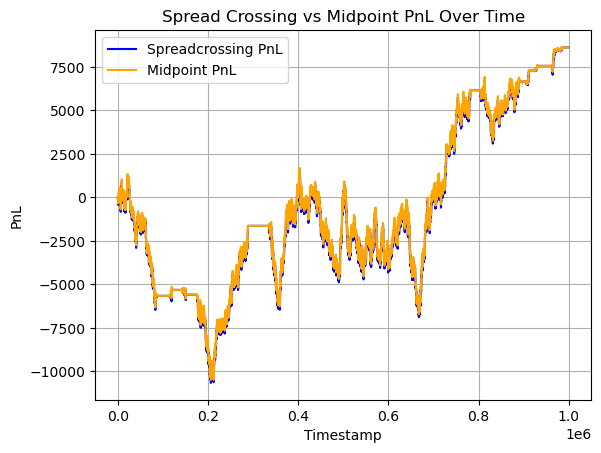

In [28]:
import matplotlib.pyplot as plt    
product = "PICNIC_BASKET2"

resin_metrics = bt.calculate_metrics(product)
print(f"PNL: {bt.pnl}")

print(f"Midpoint Sharpe: {resin_metrics['midpoint_sharpe']:.4f}")
print(f"Spreadcrossing Sharpe: {resin_metrics['spreadcrossing_sharpe']:.4f}")
print(f"Midpoint PnL (bps): {resin_metrics['midpoint_pnl_bps']:.2f}")
print(f"Spreadcrossing PnL (bps): {resin_metrics['spreadcrossing_pnl_bps']:.2f}")

# THIS PART PLOTS SPREADCROSSING_PNL AND MIDPOINT_PNL
spreadcrossing_pnl_history = bt.get_metric("spreadcrossing_pnl", product)
midpoint_pnl_history = bt.get_metric("midpoint_pnl", product)
timestamps = np.unique(bt.market_data["timestamp"])

plt.plot(timestamps, spreadcrossing_pnl_history, label="Spreadcrossing PnL", color="blue")
plt.plot(timestamps, midpoint_pnl_history, label="Midpoint PnL", color="orange")
plt.xlabel("Timestamp")
plt.ylabel("PnL")
plt.title("Spread Crossing vs Midpoint PnL Over Time")
plt.legend()
plt.grid(True)
plt.show()


You can copy paste everything, except for the Trader algo, which should be whatever algo you wish to backtest.

In [330]:
edge_0 = 70
edge_max = 150

edge_max_retreet = 100
edge_0_retreet = 0

position_max = int(250/4)

In [331]:
pos_sell = exit_size_function(95, edge_0_retreet, edge_max_retreet, position_max)
pos_sell

-61.845

In [332]:
size_function(133, edge_0, edge_max, position_max)

-38.449687499999996